In [80]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn 
import os 

In [81]:
import pyodbc
from sqlalchemy import create_engine
from sqlalchemy.engine import URL

# create engine with sqlalchemy because is compatible with last versions
server = 'DESKTOP-LSBEE1U' 
database = 'dm_vendas_br' 

connection_string = 'DRIVER={SQL Server};SERVER='+server+';DATABASE='+database
connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": connection_string})
engine = create_engine(connection_url)


In [82]:
df = pd.read_sql('select * from dbo.compras',engine)
df.head()

cliente_id  valor_compra data_compra
0         760          25.0  2009-11-06
1         860          50.0  2012-09-28
2        1200         100.0  2005-10-25
3        1420          50.0  2009-07-09
4        1940          70.0  2013-01-25

In [83]:
df.dtypes

cliente_id        int64
valor_compra    float64
data_compra      object
dtype: object

Formatando os dados 

In [84]:
from  datetime import date 

df.data_compra = pd.to_datetime(df.data_compra)
df.data_compra

0       2009-11-06
1       2012-09-28
2       2005-10-25
3       2009-07-09
4       2013-01-25
           ...    
51238   2011-11-12
51239   2013-11-15
51240   2014-12-23
51241   2015-05-28
51242   2011-11-30
Name: data_compra, Length: 51243, dtype: datetime64[ns]

In [85]:
df.describe()

cliente_id   valor_compra
count   51243.000000   51243.000000
mean   108934.547938      80.343149
std     67650.610139    1248.486092
min        10.000000       5.000000
25%     57720.000000      25.000000
50%    102440.000000      30.000000
75%    160525.000000      60.000000
max    264200.000000  180545.000000

In [86]:
sql ='''
        SELECT CLIENTE_ID,
	       VALOR_COMPRA,
	       DATA_COMPRA,
	       DATEDIFF(MONTH,DATA_COMPRA,GETDATE()) [DIFERENCA EM MESES]
          FROM [DBO].[COMPRAS] '''

pd.read_sql(sql,engine)

CLIENTE_ID  VALOR_COMPRA DATA_COMPRA  DIFERENCA EM MESES
0             760          25.0  2009-11-06                 152
1             860          50.0  2012-09-28                 118
2            1200         100.0  2005-10-25                 201
3            1420          50.0  2009-07-09                 156
4            1940          70.0  2013-01-25                 114
...           ...           ...         ...                 ...
51238      163230          30.0  2011-11-12                 128
51239      154410         100.0  2013-11-15                 104
51240      189270          30.0  2014-12-23                  91
51241      173810          30.0  2015-05-28                  86
51242        9830          50.0  2011-11-30                 128

[51243 rows x 4 columns]

Selecionando o top 10 clientes com maiores valores gastos

In [87]:
df_cli10 =\
   df.loc[:,['valor_compra','cliente_id']].\
   groupby('cliente_id').sum().\
   sort_values(by='valor_compra',ascending=False).\
   head(10)

In [88]:
df_cli10['rank'] = df_cli10.rank(ascending=False)
df_cli10['rank'] = df_cli10['rank'].astype('int')
df_cli10

valor_compra  rank
cliente_id                    
94390           180575.0     1
234230          118421.0     2
223100          112922.0     3
76190            93290.0     4
215470           88889.0     5
148800           55432.0     6
193210           36949.0     7
14690            30490.0     8
174170           27534.0     9
13610            24350.0    10

In [89]:
# 
df_cli10['valor_compra'].mean()

76885.2

In [90]:
df['valor_compra'].mean()

80.34314930819819

In [91]:
df.shape

(51243, 3)

In [92]:
import plotly.express as pl 
pl.box(df['valor_compra'])

In [93]:
def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   lim_inf = (q1-1.5*IQR)
   lim_sup = (q3+1.5*IQR)
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]# buscamos dados acima do limite inferior e sup
   return outliers,lim_inf,lim_sup

In [94]:
outliers,lim_inf,lim_sup = find_outliers_IQR(df['valor_compra'])

In [95]:
# prova real da quantidade de valores assima ou abaixo dos limites 

len(df['valor_compra']) - (len(df['valor_compra']) - len(outliers) ) 

3582

In [96]:
df['ano'] = df['data_compra'].apply(lambda x:x.year)
df['ano']

0        2009
1        2012
2        2005
3        2009
4        2013
         ... 
51238    2011
51239    2013
51240    2014
51241    2015
51242    2011
Name: ano, Length: 51243, dtype: int64

In [97]:
total_compra_ano =\
    df.loc[:,['ano','valor_compra']].\
    groupby(['ano']).sum().\
    sort_values(by='valor_compra')

In [98]:
total_compra_ano.columns


Index(['valor_compra'], dtype='object')

<AxesSubplot:xlabel='ano'>

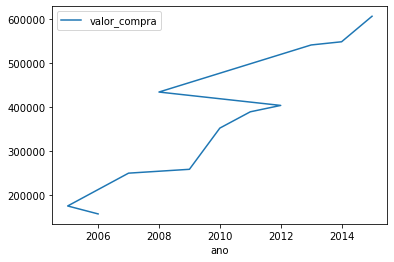

In [99]:
total_compra_ano.plot()

In [100]:
total_compra_ano['year'] = total_compra_ano.index


In [101]:
# remove name of index 
total_compra_ano.index.name = None
total_compra_ano.index =  range(0,11) # create range 

total_compra_ano

valor_compra  year
0       158051.0  2006
1       176037.0  2005
2       250357.0  2007
3       259064.0  2009
4       352389.0  2010
5       389263.0  2011
6       403716.0  2012
7       434034.0  2008
8       540615.0  2013
9       547849.0  2014
10      605649.0  2015

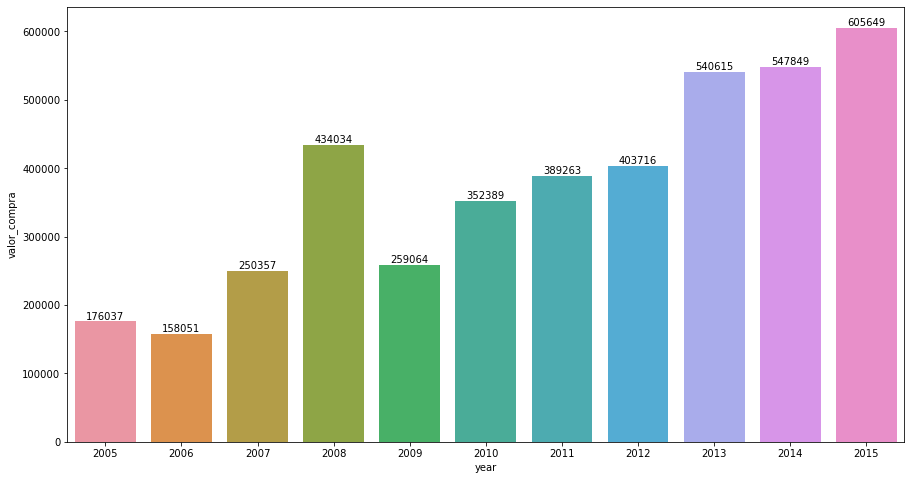

In [102]:
plt.figure(figsize=(15,8))# larg , alt 
ax = sn.barplot(x='year',y='valor_compra',data=total_compra_ano);
ax.bar_label(ax.containers[0]);

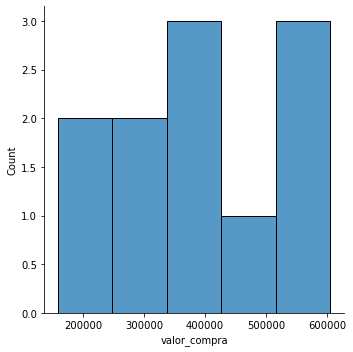

In [103]:
sn.displot(total_compra_ano['valor_compra']);

In [104]:
# nesse caso a mode e inutil para assimetria, pois baseamos no agrupamento dos dados 
total_compra_ano.agg({'valor_compra':['mean','median']})

valor_compra
mean    374274.909091
median  389263.000000

normalizacao com log, aproximando valores diminuindo a negatividade da assimetria

outras normalizações penalizao os valores a ponto no log eu consigo transformar todos para mesma base

In [105]:
import math 

np.random.seed(777)
df['valor_compra'] = np.log(df['valor_compra'])
df['valor_compra'].values

array([3.21887582, 3.91202301, 4.60517019, ..., 3.40119738, 3.40119738,
       3.91202301])

In [106]:
pl.box(df['valor_compra'])

<Figure size 720x720 with 0 Axes>

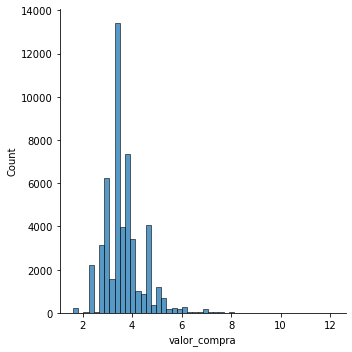

In [107]:
plt.figure(figsize=(10,10));
sn.displot(df['valor_compra'],bins=50);
plt.show()

In [108]:
total_compra_ano.agg({'valor_compra':['mean','median']})

valor_compra
mean    374274.909091
median  389263.000000

In [109]:
from scipy.stats import skew

skew(df['valor_compra']) # assimetrica positiva

1.2739060034611964

In [110]:
from scipy.stats import kurtosistest

kurtosistest(df['valor_compra'])# discrepancia impedi que consideremos os dados como normais apessar de sua escala responder como 

KurtosistestResult(statistic=74.75111593854491, pvalue=0.0)

segementacao

formula de Sturges: defini o numero de cortes no tamanho da basse<br>
K= 1 + 3.3 * logN<br><br>
k = classes ou numero de cortes <br> 
amplitude total = diferenca entre o maior e menor valor no rol<br>
intervalo =  e o valor no qual assumo para pegar de um ponto a outro [n,n+8)
                                                                    

In [111]:
amplitude =df.iloc[:,1].max()-df.iloc[:,1].min()
k = np.round(1+3.3*np.log(len(df.iloc[:,1])))# descobre o numero de classes(cortes)
intervalo = amplitude/k
intervalo
pd.cut(x=df.iloc[:,1],bins=int(k))

0        (3.028, 3.311]
1        (3.878, 4.162]
2        (4.446, 4.729]
3        (3.878, 4.162]
4        (4.162, 4.446]
              ...      
51238    (3.311, 3.595]
51239    (4.446, 4.729]
51240    (3.311, 3.595]
51241    (3.311, 3.595]
51242    (3.878, 4.162]
Name: valor_compra, Length: 51243, dtype: category
Categories (37, interval[float64, right]): [(1.599, 1.893] < (1.893, 2.177] < (2.177, 2.46] < (2.46, 2.744] ... (10.969, 11.253] < (11.253, 11.536] < (11.536, 11.82] < (11.82, 12.104]]

In [112]:
df['classe_compra'] = pd.cut(x=df.iloc[:,1],bins=int(k))
df

cliente_id  valor_compra data_compra   ano   classe_compra
0             760      3.218876  2009-11-06  2009  (3.028, 3.311]
1             860      3.912023  2012-09-28  2012  (3.878, 4.162]
2            1200      4.605170  2005-10-25  2005  (4.446, 4.729]
3            1420      3.912023  2009-07-09  2009  (3.878, 4.162]
4            1940      4.248495  2013-01-25  2013  (4.162, 4.446]
...           ...           ...         ...   ...             ...
51238      163230      3.401197  2011-11-12  2011  (3.311, 3.595]
51239      154410      4.605170  2013-11-15  2013  (4.446, 4.729]
51240      189270      3.401197  2014-12-23  2014  (3.311, 3.595]
51241      173810      3.401197  2015-05-28  2015  (3.311, 3.595]
51242        9830      3.912023  2011-11-30  2011  (3.878, 4.162]

[51243 rows x 5 columns]

In [113]:
from sklearn.preprocessing import LabelEncoder

lbl_enc = LabelEncoder()
df['classe_compra_cod'] = lbl_enc.fit_transform(df['classe_compra'])
df

cliente_id  valor_compra data_compra   ano   classe_compra  \
0             760      3.218876  2009-11-06  2009  (3.028, 3.311]   
1             860      3.912023  2012-09-28  2012  (3.878, 4.162]   
2            1200      4.605170  2005-10-25  2005  (4.446, 4.729]   
3            1420      3.912023  2009-07-09  2009  (3.878, 4.162]   
4            1940      4.248495  2013-01-25  2013  (4.162, 4.446]   
...           ...           ...         ...   ...             ...   
51238      163230      3.401197  2011-11-12  2011  (3.311, 3.595]   
51239      154410      4.605170  2013-11-15  2013  (4.446, 4.729]   
51240      189270      3.401197  2014-12-23  2014  (3.311, 3.595]   
51241      173810      3.401197  2015-05-28  2015  (3.311, 3.595]   
51242        9830      3.912023  2011-11-30  2011  (3.878, 4.162]   

       classe_compra_cod  
0                      5  
1                      8  
2                     10  
3                      8  
4                      9  
...                  ...  
51238                  6  
51239                 10  
51240                  6  
51241                  6  
51242                  8  

[51243 rows x 6 columns]

In [114]:
df.iloc[:,[0,1,4]].dtypes

cliente_id          int64
valor_compra      float64
classe_compra    category
dtype: object

In [115]:
df.iloc[:,[0,1,4]].values.reshape(1, -1).ravel()

array([760, 3.2188758248682006, Interval(3.028, 3.311, closed='right'),
       ..., 9830, 3.912023005428146,
       Interval(3.878, 4.162, closed='right')], dtype=object)

valores concentrados, pois tratam de faixas de valore, e classe azul de fato representa os valores outiliers, porem nao podemos remover pois tarta-se de uma classe rara

In [116]:
sql ='''
        SELECT CLIENTE_ID,
	       VALOR_COMPRA,
	       DATA_COMPRA,
	       DATEDIFF(MONTH,DATA_COMPRA,GETDATE()) [DIFERENCA EM MESES]
          FROM [DBO].[COMPRAS] '''

df2 = pd.read_sql(sql,engine)
df2

CLIENTE_ID  VALOR_COMPRA DATA_COMPRA  DIFERENCA EM MESES
0             760          25.0  2009-11-06                 152
1             860          50.0  2012-09-28                 118
2            1200         100.0  2005-10-25                 201
3            1420          50.0  2009-07-09                 156
4            1940          70.0  2013-01-25                 114
...           ...           ...         ...                 ...
51238      163230          30.0  2011-11-12                 128
51239      154410         100.0  2013-11-15                 104
51240      189270          30.0  2014-12-23                  91
51241      173810          30.0  2015-05-28                  86
51242        9830          50.0  2011-11-30                 128

[51243 rows x 4 columns]

In [117]:
pd.cut(df2['DIFERENCA EM MESES'],bins=10)

0        (144.5, 157.6]
1        (105.2, 118.3]
2        (196.9, 210.0]
3        (144.5, 157.6]
4        (105.2, 118.3]
              ...      
51238    (118.3, 131.4]
51239     (92.1, 105.2]
51240    (78.869, 92.1]
51241    (78.869, 92.1]
51242    (118.3, 131.4]
Name: DIFERENCA EM MESES, Length: 51243, dtype: category
Categories (10, interval[float64, right]): [(78.869, 92.1] < (92.1, 105.2] < (105.2, 118.3] < (118.3, 131.4] ... (157.6, 170.7] < (170.7, 183.8] < (183.8, 196.9] < (196.9, 210.0]]

In [118]:
clientes_quase_inativos = df2[df2['DIFERENCA EM MESES'] <157]
clientes_quase_inativos

CLIENTE_ID  VALOR_COMPRA DATA_COMPRA  DIFERENCA EM MESES
0             760          25.0  2009-11-06                 152
1             860          50.0  2012-09-28                 118
3            1420          50.0  2009-07-09                 156
4            1940          70.0  2013-01-25                 114
5            1960          40.0  2013-10-29                 105
...           ...           ...         ...                 ...
51238      163230          30.0  2011-11-12                 128
51239      154410         100.0  2013-11-15                 104
51240      189270          30.0  2014-12-23                  91
51241      173810          30.0  2015-05-28                  86
51242        9830          50.0  2011-11-30                 128

[36757 rows x 4 columns]

In [119]:
# 28% dos clientes estao inativos
1-len(clientes_quase_inativos)/len(df2) 


0.28269227016372966

In [120]:
ativos =df2[~df2.CLIENTE_ID.isin(clientes_quase_inativos.CLIENTE_ID)]

In [121]:
ativos['DIFERENCA EM MESES'].max()

210

In [122]:
ativos['Segmento']= pd.cut(ativos['DIFERENCA EM MESES'],bins=5,labels=['Quente','Novo Quente','Novo Ativo',
                                                    'Ativo- valor baixo','Ativo - valor Alto'])

C:\Users\Familia\AppData\Local\Temp\ipykernel_9540\357699341.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [123]:
ativos

CLIENTE_ID  VALOR_COMPRA DATA_COMPRA  DIFERENCA EM MESES  \
16           4840          30.0  2005-10-14                 201   
23           6240         100.0  2006-11-09                 188   
24           6390          15.0  2005-10-25                 201   
26           6600          50.0  2005-09-23                 202   
39           7740         100.0  2007-08-09                 179   
...           ...           ...         ...                 ...   
51177       79730          10.0  2007-08-08                 179   
51185       12790          30.0  2008-04-05                 171   
51206       85740          30.0  2007-11-07                 176   
51221       78290          10.0  2007-07-20                 180   
51222       65460          20.0  2007-03-13                 184   

                 Segmento  
16     Ativo - valor Alto  
23             Novo Ativo  
24     Ativo - valor Alto  
26     Ativo - valor Alto  
39             Novo Ativo  
...                   ...  
51177          Novo Ativo  
51185         Novo Quente  
51206         Novo Quente  
51221          Novo Ativo  
51222          Novo Ativo  

[4951 rows x 5 columns]

In [124]:
ativos_seg = ativos[['VALOR_COMPRA','Segmento']].groupby('Segmento').agg({'VALOR_COMPRA':['mean','sum']})
ativos_seg

VALOR_COMPRA         
                           mean      sum
Segmento                                
Quente                45.613787  54919.0
Novo Quente           67.095821  93129.0
Novo Ativo            43.125693  69993.0
Ativo- valor baixo   175.739437  49910.0
Ativo - valor Alto   179.668142  81210.0

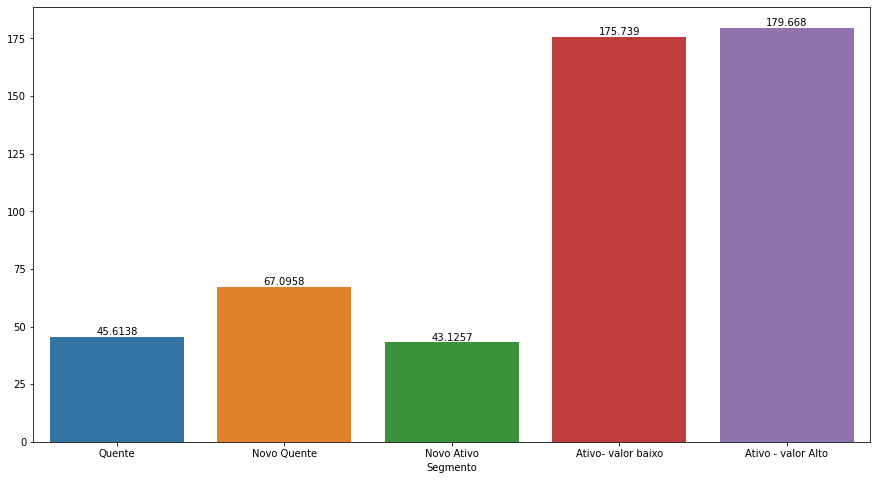

In [125]:
plt.figure(figsize=(15,8))
ax = sn.barplot(x=ativos_seg['VALOR_COMPRA','mean'].index,y=ativos_seg['VALOR_COMPRA','mean'].values)
ax.bar_label(ax.containers[0]);

In [126]:
import statsmodels.api as sm

In [127]:
from sklearn.preprocessing import LabelEncoder

lbl_enc = LabelEncoder()
ativos['Segmento_cod'] = lbl_enc.fit_transform(ativos['Segmento'])
ativos

C:\Users\Familia\AppData\Local\Temp\ipykernel_9540\3772499347.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



CLIENTE_ID  VALOR_COMPRA DATA_COMPRA  DIFERENCA EM MESES  \
16           4840          30.0  2005-10-14                 201   
23           6240         100.0  2006-11-09                 188   
24           6390          15.0  2005-10-25                 201   
26           6600          50.0  2005-09-23                 202   
39           7740         100.0  2007-08-09                 179   
...           ...           ...         ...                 ...   
51177       79730          10.0  2007-08-08                 179   
51185       12790          30.0  2008-04-05                 171   
51206       85740          30.0  2007-11-07                 176   
51221       78290          10.0  2007-07-20                 180   
51222       65460          20.0  2007-03-13                 184   

                 Segmento  Segmento_cod  
16     Ativo - valor Alto             0  
23             Novo Ativo             2  
24     Ativo - valor Alto             0  
26     Ativo - valor Alto             0  
39             Novo Ativo             2  
...                   ...           ...  
51177          Novo Ativo             2  
51185         Novo Quente             3  
51206         Novo Quente             3  
51221          Novo Ativo             2  
51222          Novo Ativo             2  

[4951 rows x 6 columns]

In [128]:
from sklearn.model_selection import train_test_split

y = ativos.iloc[:,5].values
x = ativos.iloc[:,[1,3]].values 

X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=777)


model_t = sm.OLS(y_train,X_train).fit()
model_t.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.765
Model:                            OLS   Adj. R-squared (uncentered):              0.765
Method:                 Least Squares   F-statistic:                              5637.
Date:                Sun, 03 Jul 2022   Prob (F-statistic):                        0.00
Time:                        16:44:30   Log-Likelihood:                         -5963.3
No. Observations:                3465   AIC:                                  1.193e+04
Df Residuals:                    3463   BIC:                                  1.194e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0001    4.2e-05     -3.518      0.000      -0.000   -6.54e-05
x2             0.0137      0.000    105.686      0.000       0.013       0.014
==============================================================================
Omnibus:                      171.924   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              184.069
Skew:                          -0.539   Prob(JB):                     1.07e-40
Kurtosis:                       2.664   Cond. No.                         3.12
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [129]:

pred = model_t.predict(X_test)


In [130]:
from sklearn.metrics import mean_squared_error,f1_score

mean_squared_error(y_test,pred)

1.854816546730113

In [132]:
# relacao linear das variaveis 

model_t.rsquared

0.7649993083309798

## ARIMA

c:\Users\Familia\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

c:\Users\Familia\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



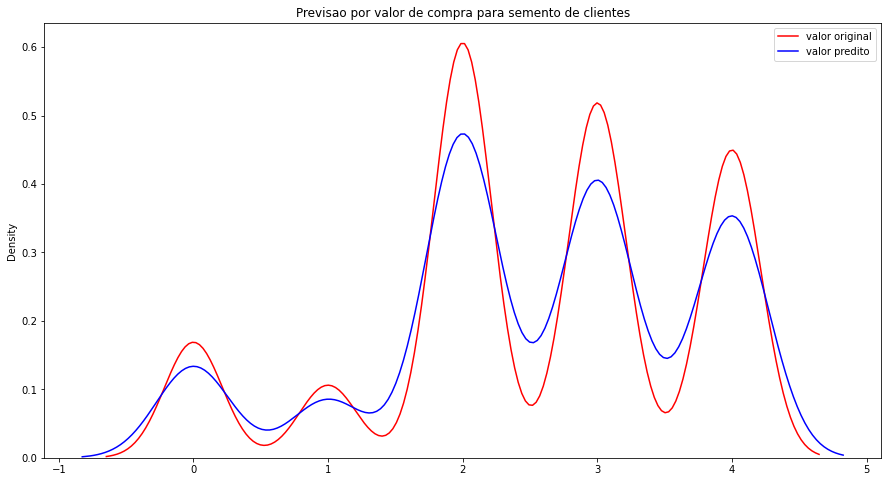

In [ ]:
plt.figure(figsize=(15,8));
plt.title('Previsao por valor de compra para semento de clientes');
ax1 = sn.distplot(y, hist=False, color="r", label="valor original");
sn.distplot(y_test, hist=False, color="b", label="valor predito" , ax=ax1);
plt.legend();

C:\Users\Familia\AppData\Local\Temp\ipykernel_5180\4232587384.py:5: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



<Figure size 1500x800 with 0 Axes>

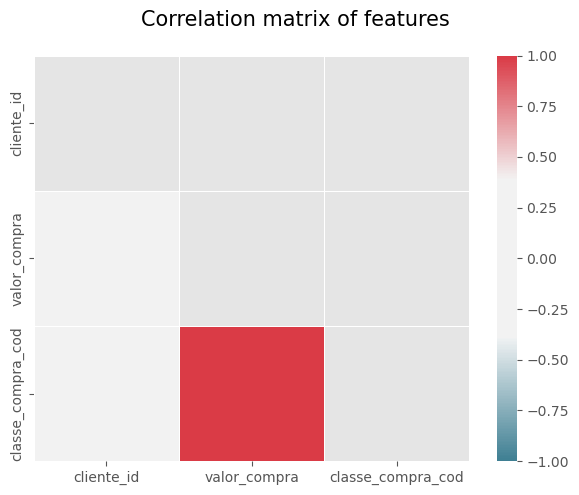

In [ ]:
plt.figure(figsize=(15,8));
corr = df.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(6, 5))

# Generate a custom diverging colormap
cmap = sn.diverging_palette(220, 10, as_cmap=True, sep=100)

# Draw the heatmap with the mask and correct aspect ratio
sn.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5)

fig.suptitle('Correlation matrix of features', fontsize=15)


fig.tight_layout()

In [ ]:
total_compra_ano

valor_compra  year
0       158051.0  2006
1       176037.0  2005
2       250357.0  2007
3       259064.0  2009
4       352389.0  2010
5       389263.0  2011
6       403716.0  2012
7       434034.0  2008
8       540615.0  2013
9       547849.0  2014
10      605649.0  2015

In [133]:
df['data_compra'] = pd.to_datetime(df['data_compra'])
df['ano'] = df['data_compra'].apply(lambda x:x.year)
df

cliente_id  valor_compra data_compra   ano   classe_compra  \
0             760      3.218876  2009-11-06  2009  (3.028, 3.311]   
1             860      3.912023  2012-09-28  2012  (3.878, 4.162]   
2            1200      4.605170  2005-10-25  2005  (4.446, 4.729]   
3            1420      3.912023  2009-07-09  2009  (3.878, 4.162]   
4            1940      4.248495  2013-01-25  2013  (4.162, 4.446]   
...           ...           ...         ...   ...             ...   
51238      163230      3.401197  2011-11-12  2011  (3.311, 3.595]   
51239      154410      4.605170  2013-11-15  2013  (4.446, 4.729]   
51240      189270      3.401197  2014-12-23  2014  (3.311, 3.595]   
51241      173810      3.401197  2015-05-28  2015  (3.311, 3.595]   
51242        9830      3.912023  2011-11-30  2011  (3.878, 4.162]   

       classe_compra_cod  
0                      5  
1                      8  
2                     10  
3                      8  
4                      9  
...                  ...  
51238                  6  
51239                 10  
51240                  6  
51241                  6  
51242                  8  

[51243 rows x 6 columns]

In [134]:
df3 =  ativos.merge(df,left_on='CLIENTE_ID',right_on='cliente_id')

PREVENDO VALOR ANUAL DE COMPRAS POR SEMGENTO

In [135]:
df3.head(3)

CLIENTE_ID  VALOR_COMPRA DATA_COMPRA  DIFERENCA EM MESES  \
0        4840          30.0  2005-10-14                 201   
1        6240         100.0  2006-11-09                 188   
2        6240         100.0  2006-11-09                 188   

             Segmento  Segmento_cod  cliente_id  valor_compra data_compra  \
0  Ativo - valor Alto             0        4840      3.401197  2005-10-14   
1          Novo Ativo             2        6240      4.605170  2006-11-09   
2          Novo Ativo             2        6240      4.605170  2005-09-23   

    ano   classe_compra  classe_compra_cod  
0  2005  (3.311, 3.595]                  6  
1  2006  (4.446, 4.729]                 10  
2  2005  (4.446, 4.729]                 10

In [136]:
s_ativos  = df3.loc[:,'VALOR_COMPRA'].squeeze()
s_ativos

0        30.0
1       100.0
2       100.0
3       100.0
4       100.0
        ...  
8876     20.0
8877     10.0
8878     30.0
8879     10.0
8880     20.0
Name: VALOR_COMPRA, Length: 8881, dtype: float64

In [137]:
s_ativos = s_ativos.set_axis(df3.loc[:,'data_compra'])
s_ativos = s_ativos[:800]

In [138]:
from pmdarima.arima import auto_arima

In [139]:
stepwise=auto_arima(s_ativos,
                    start_p=0,
                    start_q=0,
                    d=0,
                    max_p=6,
                    max_q=6,
                    max_d=2,
                    start_P=1,
                    start_Q=1,
                    D=1,
                    max_P=2, max_D=1, max_Q=2, max_order=5,
                    m=12,
                    seasonal=True,
                    trace=True,
                    error_action='ignore',suppress_warnings=True,
                    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.84 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=12749.438, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=12527.300, Time=1.56 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.86 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=12747.442, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=12750.033, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=12435.724, Time=6.08 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=17.06 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=4.22 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=12433.728, Time=7.53 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=12525.368, Time=2.19 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=14.55 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=12435.724, Time=5.69 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=inf, Time=10.06 sec
 ARIMA(0,0,0)(2,1,0)[12]             :

In [239]:
stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                  500
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood               -3964.687
Date:                  Sun, 03 Jul 2022   AIC                           7935.373
Time:                          18:07:45   BIC                           7947.944
Sample:                               0   HQIC                          7940.311
                                  - 500                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6610      0.007    -90.591      0.000      -0.675      -0.647
ar.S.L24      -0.3265      0.007    -43.940      0.000      -0.341      -0.312
sigma2      6.949e+05   4102.864    169.380      0.000    6.87e+05    7.03e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):           1364936.55
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):             100.61   Skew:                            12.02
Prob(H) (two-sided):                  0.00   Kurtosis:                       260.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [240]:
treino=s_ativos[:700]
teste=s_ativos[700:800]

In [375]:
previsao=stepwise.predict(n_periods=36)

In [376]:
import pandas as pd
from datetime import *


datelist = pd.date_range(start=date(2005,4,24), end=date(2007,4,27), periods=36).tolist()

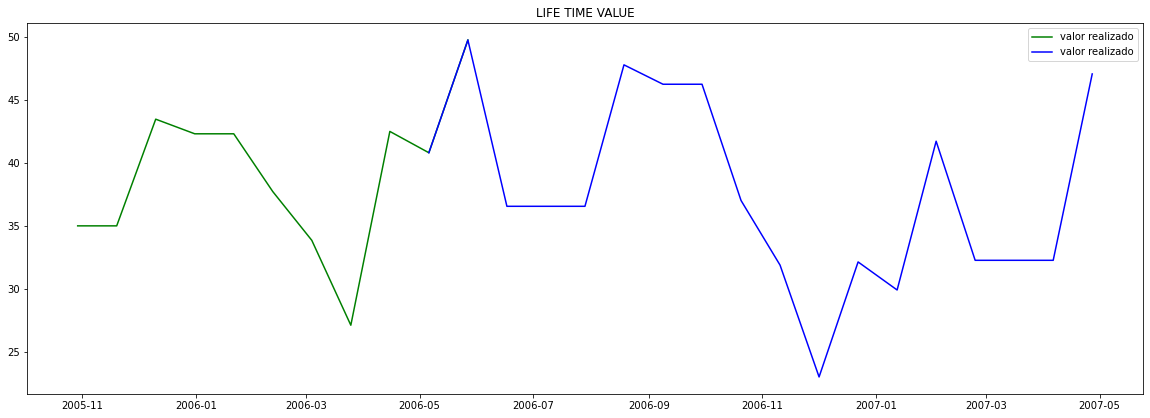

In [388]:

plt.figure(figsize=(20,15))
plt.subplot(211)
plt.title('LIFE TIME VALUE')
plt.plot(prev.index,prev.values,color='g',label="valor realizado")
plt.plot(tr.index,tr.values,color='b',label="valor previsto")
plt.legend()

plt.show()

In [393]:
clientes_quase_inativos.to_excel('dados2.xlsx')